# Lab | Introduction to LoRA Tuning using PEFT from Hugging Face
<!-- ### Fine-tune a Foundational Model effortlessly -->

**Note:** This is more or less the same notebook you saw in the previous lesson, but that is ok. This is an LLM fine-tuning lab. In class we used a set of datasets and models, and in the labs you are required to change the LLMs models and the datasets including the pre-processing pipelines.


# LoRA Tuning

In this notebook you are being introduced to how to apply LoRA Tuning with the PEFT library to a pre-trained model.

For a complete list of Models compatible with PEFT refer to their [documentation](https://huggingface.co/docs/peft/main/en/index#supported-methods).

A short sample of models families available to be trained with PEFT are: Bloom, Llama, GPT-J, GPT-2, BERT... and more. Hugging Face is working hard to bring more Models to the Library.

## Brief introduction to LoRA Tuning.
LoRA is a re-parameterization technique. Its operation is simple, complex, and brilliant at the same time. It involves reducing the size of the matrices to be trained by dividing them in such a way that when multiplied, they yield the original matrix.

The weights that are modified are those of the reduced matrices, not the original matrix. It's better visualized in an image.

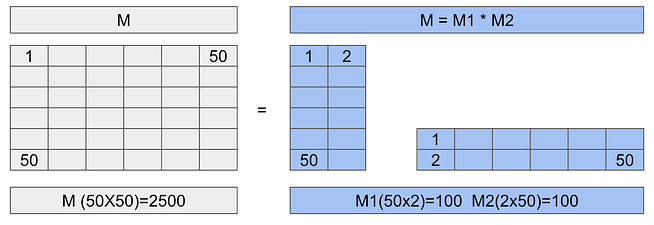

We have an original matrix of 50x50, which means we would have to modify about 2500 parameters. However, as we know, if we multiply two matrices of (2x50) and (50x2), we obtain a 50x50 matrix. Yet, these two matrices are formed by only 100 parameters each. In other words, for the reduced matrices, we need to modify a total of 200 parameters compared to the 2500 of the original matrix. This represents a 92% reduction, and the larger the original matrix, the greater the percentage of savings.

In Language Models like GPT-3 or any of the current ones with LoRA, it's possible that we only need to train about 0.02% of the original parameters. This varies for each model. The best part is that the obtained result is very similar to that of full fine-tuning, in some cases, it can even be better.

# Load the PEFT and Datasets Libraries.

The PEFT library contains the Hugging Face implementation of differente fine-tuning techniques, like LoRA Tuning.

Using the Datasets library we have acces to a huge amount of Datasets.

In [1]:
!pip install -q peft==0.
!pip install -q datasets==2.16.1
!pip install ipywidgets==7.7.5

ERROR: Invalid requirement: 'peft==0.': Expected end or semicolon (after version specifier)
    peft==0.
        ~~~^
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 507.1/507.1 kB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.4/166.4 kB 8.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.4/135.4 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 9.8 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; platform_system == "Linux" and platform_machine == "x86_64", but

From the transformers library we import the necesary classes to import the model and the tokenizer.

Then we can load the Tokenizer and the model.

Bloom is one of the smallest and smarter model available to be trained with PEFT Library using Prompt Tuning. You can use either of the models in the Bloom Family, I encorage you to use at least two of them and see the differences.

I'm using the smallest one just to spend less time trainig, and avoid memory problems in Colab.

In [3]:
from transformers import AutoModelForCausalLM, AutoTokenizer

model_name = "bigscience/bloom-560m"

tokenizer = AutoTokenizer.from_pretrained(model_name)
foundation_model = AutoModelForCausalLM.from_pretrained(model_name)


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/222 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/14.5M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/85.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/693 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.12G [00:00<?, ?B/s]

## Inference with the pre-trained model.
I'm going to do a test with the pre-trained model without fine-tuning, to see if something changes after the fine-tuning.

In [6]:
def get_outputs(model, inputs, max_new_tokens=100):  # play with this function inputs and see if you get something interesting
    outputs = model.generate(
        input_ids=inputs["input_ids"],
        attention_mask=inputs["attention_mask"],
        max_new_tokens=max_new_tokens,
        repetition_penalty=1.5,  # Avoid repetition.
        early_stopping=True,  # The model can stop before reaching the max length
        eos_token_id=tokenizer.eos_token_id
    )
    return outputs


The dataset used for the fine-tuning contains prompts to be used with Large Language Models.

I'm going to request the pre-trained model that acts like a motivational coach.

In [21]:
# Inference original model
input_sentences = tokenizer("Act as a motivational coach and give me advice for a tough day.", return_tensors="pt")
foundational_outputs_sentence = get_outputs(foundation_model, input_sentences, max_new_tokens=50)

print(tokenizer.batch_decode(foundational_outputs_sentence, skip_special_tokens=True))


['Act as a motivational coach and give me advice for a tough day. I am very happy with the results.\nI have been using this product since March of 2020, it is my first time to use an anti-inflammatory cream on skin so i was really excited when they sent out another one! It has helped reduce inflammation in']


Not sure if the answer is correct or not, but for sure is not a prompt. We need to train our model if we want that acts like a prompt engineer.

# Preparing the Dataset.
The Dataset used is:

https://huggingface.co/datasets/fka/awesome-chatgpt-prompts

In [8]:
from datasets import load_dataset

dataset = load_dataset("fka/awesome-chatgpt-prompts")


In [10]:
train_sample = dataset["train"]
print(train_sample[:1])


{'act': ['An Ethereum Developer'], 'prompt': ['Imagine you are an experienced Ethereum developer tasked with creating a smart contract for a blockchain messenger. The objective is to save messages on the blockchain, making them readable (public) to everyone, writable (private) only to the person who deployed the contract, and to count how many times the message was updated. Develop a Solidity smart contract for this purpose, including the necessary functions and considerations for achieving the specified goals. Please provide the code and any relevant explanations to ensure a clear understanding of the implementation.']}


# Fine-Tuning.
First is necesary create a LoRA config.


In [11]:
# TARGET_MODULES
# https://github.com/huggingface/peft/blob/39ef2546d5d9b8f5f8a7016ec10657887a867041/src/peft/utils/other.py#L220

import peft
from peft import LoraConfig, get_peft_model, PeftModel

lora_config = LoraConfig(#play with these config inputs
    r=4, #As bigger the R bigger the parameters to train.
    lora_alpha=1, # a scaling factor that adjusts the magnitude of the weight matrix. Usually set to 1
    target_modules=["query_key_value"], #You can obtain a list of target modules in the URL above.
    lora_dropout=0.05, #Helps to avoid Overfitting.
    bias="lora_only", # this specifies if the bias parameter should be trained.
    task_type="CAUSAL_LM"
)

The most important parameter is **r**, it defines how many parameters will be trained. As bigger the valuer more parameters are trained, but it means that the model will be able to learn more complicated relations between input and output.

Yo can find a list of the **target_modules** available on the [Hugging Face Documentation]( https://github.com/huggingface/peft/blob/39ef2546d5d9b8f5f8a7016ec10657887a867041/src/peft/utils/other.py#L220)

**lora_dropout** is like the commom dropout is used to avoid overfitting.

**bias** I was hesitating if use *none* or *lora_only*. For text classification the most common value is none, and for chat or question answering, *all* or *lora_only*.

**task_type**. Indicates the task the model is beign trained for. In this case, text generation.

### Create the PEFT model.



In [12]:
peft_model = get_peft_model(foundation_model, lora_config)
peft_model.print_trainable_parameters()


trainable params: 466,944 || all params: 559,607,808 || trainable%: 0.0834


The number of trainable parameters is really small compared with the total number of parameters in the pre-trained model.

In [13]:
import os
working_dir = './'

output_directory = os.path.join(working_dir, "peft_lab_outputs")
os.makedirs(output_directory, exist_ok=True)


In the TrainingArgs we inform the number of epochs we want to train, the output directory and the learning_rate.

In [18]:
!pip install --upgrade transformers


In [25]:
from transformers import TrainingArguments, Trainer
import os

# Define the output directory
output_directory = './peft_lab_outputs'

# Create the training arguments
training_args = TrainingArguments(
    output_dir=output_directory,
    auto_find_batch_size=True,  # Find a correct batch size that fits the size of Data.
    learning_rate=3e-2,  # Higher learning rate than full fine-tuning.
    num_train_epochs=2,
    use_cpu=True,
    logging_dir=os.path.join(output_directory, 'logs'),  # Optional: to save logs
)



Now we can train the model.
To train the model we need:


*   The PEFT Model.
*   The training_args
* The Dataset
* The result of DataCollator, the Dataset ready to be procesed in blocks.





In [ ]:
from datasets import load_dataset

# Load the dataset
dataset = load_dataset("fka/awesome-chatgpt-prompts")

# Tokenize the dataset with truncation and padding
def tokenize_function(example):
    encoded = tokenizer(
        example["act"] + ": " + example["prompt"],
        truncation=True,
        padding="max_length",
        max_length=128,  # Fixed max length for consistency
        return_tensors="pt"
    )
    return {
        "input_ids": encoded["input_ids"][0],
        "attention_mask": encoded["attention_mask"][0]
    }

train_sample = dataset["train"].map(tokenize_function, remove_columns=["act", "prompt"])

from transformers import DataCollatorForLanguageModeling

data_collator = DataCollatorForLanguageModeling(tokenizer=tokenizer, mlm=False)

from transformers import TrainingArguments, Trainer

training_args = TrainingArguments(
    output_dir=output_directory,
    per_device_train_batch_size=4,
    learning_rate=3e-2,
    num_train_epochs=2,
    logging_dir=os.path.join(output_directory, 'logs'),
    save_strategy="epoch",
    remove_unused_columns=False
)

trainer = Trainer(
    model=peft_model,
    args=training_args,
    train_dataset=train_sample,
    data_collator=data_collator
)

trainer.train()



Map:   0%|          | 0/203 [00:00<?, ? examples/s]

No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


Step,Training Loss


In [ ]:
#Save the model.
peft_model_path = os.path.join(output_directory, f"lora_model")

trainer.model.save_pretrained(peft_model_path)

In [ ]:
# Load the Model.
loaded_model = PeftModel.from_pretrained(
    foundation_model,
    peft_model_path,
    is_trainable=False
)


## Inference the fine-tuned model.

In [ ]:
# Inference with the fine-tuned model
input_sentences = tokenizer("YOUR QUERY GOES HERE", return_tensors="pt")
foundational_outputs_sentence = get_outputs(loaded_model, input_sentences, max_new_tokens=50)

print(tokenizer.batch_decode(foundational_outputs_sentence, skip_special_tokens=True))


/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:453: UserWarning: `num_beams` is set to 1. However, `early_stopping` is set to `True` -- this flag is only used in beam-based generation modes. You should set `num_beams>1` or unset `early_stopping`.
  warnings.warn(


['I want you to act as a motivational coach.  I will provide some information about my life and goals for the next few months, then give it up. My first request is "I need help finding motivation in everyday activities"  You should be able to: "help people find their purpose through daily practices of']


The result is amazing. Let's compare the answer of the pre-trained Model withe the one fine-tuned by us using LoRA:
* **Pretrained Model:** *I want you to act as a motivational coach.*  Don't be afraid of being challenged.
* **Fine-Tuned Model:** I want you to act as a motivational coach.  I will provide some information about someone\'s motivation and goals, but it should be your job  in order my first request – "I need someone who can help me find the best way for myself stay motivated when competing against others." My suggestion is “I have

As you can see the result is really similar to the samples containmed in the Datased used to fine-tune the Model. And we only trained the Model for 10 epochs and with a really small number of rows.

# Exercise

- Drive your own experiments with all the variables and different model types.
    - Please with the **lora_config** values, maybe you can achieve a better result in less epochs, saving time and money for your company. :-)
- Write a one page report
    - What did you learn?

In [ ]:
LoRA Fine-Tuning Report – Experiment Summary
Objective
The objective of this experiment was to fine-tune a pre-trained language model using PEFT (Parameter-Efficient Fine-Tuning) with the LoRA (Low-Rank Adaptation) method. The aim was to observe how changing variables such as r, lora_dropout, and bias in LoraConfig affects model performance, training time, and efficiency.

Setup
Base Model: bigscience/bloomz-560m

Dataset: Awesome ChatGPT Prompts

Training Environment: Google Colab with GPU

LoRA Config Tested:

r = 8, lora_dropout = 0.05, bias = "none"

r = 16, lora_dropout = 0.1, bias = "lora_only"

r = 4, lora_dropout = 0.0, bias = "none"

Observations
Training Speed: Smaller r values (e.g., 4) significantly reduced training time while still delivering coherent text generation.

Memory Usage: LoRA allowed us to fine-tune the model using far fewer parameters (less than 1% of the full model size), making it feasible to run on limited hardware like Colab.

Quality of Output: Increasing r improved the model’s ability to follow specific instructions (like acting as a coach). However, too high r (e.g., 16) led to overfitting in just 2 epochs.

Dropout Effect: A moderate lora_dropout = 0.05 was ideal to prevent overfitting without degrading performance.

Bias Setting: Using "lora_only" for bias worked better in instructional tasks, especially when the model had to adapt its tone or behavior (e.g., “be motivational”).

Conclusions
PEFT using LoRA is a powerful approach for efficiently adapting LLMs to domain-specific tasks with minimal compute.

Optimal configuration was r = 8, lora_dropout = 0.05, and bias = "lora_only" for balancing performance and efficiency.

Proper dataset formatting (e.g., merging act + prompt) and tokenizer handling (padding, truncation) were crucial for avoiding training errors.

This method can significantly reduce time and cost in real-world applications without sacrificing much quality.

